### pitstop analysis

assumption:

1. since all the cars use the same type of tire in indycar series, the average number of laps between pitstop should be similar. the pitstop decision then can be early or late that centered around the mean.

2. influences of pitstops on the change of rank



# Imports

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch

# to use only one GPU.
# use this on r-001
# otherwise comment
import os
os.environ["CUDA_VISIBLE_DEVICES"]="7"


## Load Data

In [3]:
import os
os.getcwd()


'/scratch/hpda/indycar/predictor/notebook/DataAnalysis'

In [4]:
#
# parameters
#
#year = '2017'
year = '2018'
#event = 'Toronto'
event = 'Indy500'

inputfile = '../C_'+ event +'-' + year + '-final.csv'
outputprefix = year +'-' + event + '-'
dataset = pd.read_csv(inputfile)
dataset.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18500 entries, 0 to 18499
Data columns (total 21 columns):
rank                    18500 non-null int64
car_number              18500 non-null int64
unique_id               18500 non-null object
completed_laps          18500 non-null int64
elapsed_time            18500 non-null float64
last_laptime            18500 non-null float64
lap_status              18500 non-null object
best_laptime            18500 non-null float64
best_lap                18500 non-null object
time_behind_leader      18500 non-null float64
laps_behind_leade       18500 non-null object
time_behind_prec        18500 non-null float64
laps_behind_prec        18500 non-null object
overall_rank            18500 non-null object
overall_best_laptime    18500 non-null float64
current_status          18500 non-null object
track_status            18500 non-null object
pit_stop_count          18500 non-null object
last_pitted_lap         18500 non-null object
start_position

#### Rank Analysis

In [5]:
alldata = dataset.copy()
rankdata = alldata.rename_axis('MyIdx').sort_values(by=['elapsed_time','MyIdx'], ascending=True)
rankdata = rankdata.drop_duplicates(subset=['car_number', 'completed_laps'], keep='first')

In [ ]:
rankdata[rankdata['completed_laps']==200]

In [ ]:
rankdata[rankdata['car_number']==3]

In [8]:
def draw_boxview():
    fig, ax = plt.subplots()#1,1,figsize=(8,15))
    fig.set_size_inches(4*2,15*4)

    pits = []
    yflag = []
    #
    # car_number / lap
    #
    for row in result:

        x = carno[int(row[colid['car_number']])]
        y = int(row[colid['completed_laps']])

        if row[colid['lap_status']]=='P':
            #pitid
            pitid = pitno[int(row[colid['car_number']])]
            pitno[int(row[colid['car_number']])] += 1

            # #rank-#carno-#laps-#pitid
            #txt = '#%d\n%d-%d'%(int(row[1]), row[0], pitid)
            txt = '#%d-%d\n%d\n%d-%s'%(int(row[colid['rank']]), row[colid['car_number']],
                                   row[colid['completed_laps']], pitid, row[colid['pit_stop_count']])

            color = 'y' if row[colid['track_status']]=='Y' else 'b'

            if row[colid['current_status']] != 'Active':
                color = 'r'
            pits.append((mpatch.Rectangle((x,y), 1, 1, color = color), txt))
        else:
            #other than pitstop
            if y == 200:
                #completed cars
                txt = '#%d-%d\n%d\n%d-%s'%(int(row[colid['rank']]), row[colid['car_number']],
                                       row[colid['completed_laps']], pitid, row[colid['pit_stop_count']])
                pits.append((mpatch.Rectangle((x,y), 1, 1, color = 'b'), txt))
            elif y == 0:
                #start position
                txt = '#%s-%d'%(row[colid['start_position']], row[colid['car_number']])
                pits.append((mpatch.Rectangle((x,y), 1, 1, color = 'b'), txt))
            else:
                pits.append((mpatch.Rectangle((x,y), 1, 1, color = 'gray'), ''))

    for r in pits:
        rect = r[0]
        ax.add_artist(rect)
        rx, ry = rect.get_xy()
        cx = rx + rect.get_width()/2.0
        cy = ry + rect.get_height()/2.0

        if r[1] == '':
            ax.annotate(r[1], (cx, cy), color='gray', weight='bold', 
                    fontsize=4, ha='center', va='center')
        else:
            ax.annotate(r[1], (cx, cy), color='w', weight='bold', 
                    fontsize=4, ha='center', va='center')

    ax.set_xlim((0, 33))
    ax.set_ylim((0, 201))
    ax.set_ylabel('Lap')
    ax.set_xlabel('CarNumber')

    ax.set_aspect('equal')
    fig.tight_layout()
    fig.savefig(outputprefix + '_pitstop_bycarno_fullview.pdf')

### Observation 1

lap status 
    Indicates where the lap was completed
    T = Track, P = Pit lane.
    
track status
    G = Green
    Y = Yellow
    R = Red
    W = White
    K = Checkered
    U = Unflagged (warm up)

In [9]:
#apstatus = rankdata[rankdata['car_number'] == 1]['lap_status']
#ist(lapstatus)

#pitstop_data = rankdata[['completed_laps','rank','car_number','lap_status','track_status']]
pitstop_data = rankdata.copy()

In [89]:
#carnumber -> id
xscale=int(100/11)
carno = {}
id = 0
carnumberset = sorted(set(pitstop_data['car_number']))
for car in carnumberset:
    carno[car] = id*xscale
    id += 1

#print cars
print('carnumber:',len(carno))
print(carno)

carnumber: 33
{1: 0, 3: 9, 4: 18, 6: 27, 7: 36, 9: 45, 10: 54, 12: 63, 13: 72, 14: 81, 15: 90, 17: 99, 18: 108, 19: 117, 20: 126, 21: 135, 22: 144, 23: 153, 24: 162, 25: 171, 26: 180, 27: 189, 28: 198, 29: 207, 30: 216, 32: 225, 33: 234, 59: 243, 60: 252, 64: 261, 66: 270, 88: 279, 98: 288}


In [96]:
def init_carno(xscale):
    carno = {}
    id = 0
    carnumberset = sorted(set(pitstop_data['car_number']))
    for car in carnumberset:
        carno[car] = id*xscale
        id += 1

    #print cars
    print('carnumber:',len(carno))
    print(carno)
    return carno


In [97]:
# accumulate on pitstop number for each car
pitno = {}
for car in carno.keys():
    pitno[car] = 1

cols=['completed_laps','rank','car_number','lap_status','track_status',
    'pit_stop_count','current_status','start_position']
colid={key:idx for idx, key in enumerate(cols)}

carstatus = [[row[0], row[1],row[2],row[3],row[4],row[5],row[6],row[7]] for row in pitstop_data[
    ['completed_laps','rank','car_number','lap_status','track_status',
    'pit_stop_count','current_status','start_position']].values]

In [98]:
result[0]

[0, 1, 20, 'T', 'G', '0', 'Active', '1']

In [99]:
#draw_boxview

In [100]:
#
# plot line/bar chart
#
pits=[]
yellowflags=[]
lastflag = 'x'
for row in carstatus:
    lap = int(row[colid['completed_laps']])
    
    if row[colid['lap_status']]=='P':
        pits.append(lap)
        
    if row[colid['track_status']]=='Y':
        if lastflag != 'Y':       
            #start
            yellowflags.append(lap)
    else:
        if lastflag == 'Y':       
            #end
            yellowflags.append(lap)        
    lastflag = row[colid['track_status']]
        
#pit lap
pits = np.array(pits)
#start, end lap
yellowflags = np.array(yellowflags).reshape((-1,2))


In [27]:
yellowflags

array([[ 46,  55],
       [ 58,  63],
       [ 68,  73],
       [138, 145],
       [146, 153],
       [154, 161],
       [188, 193]])

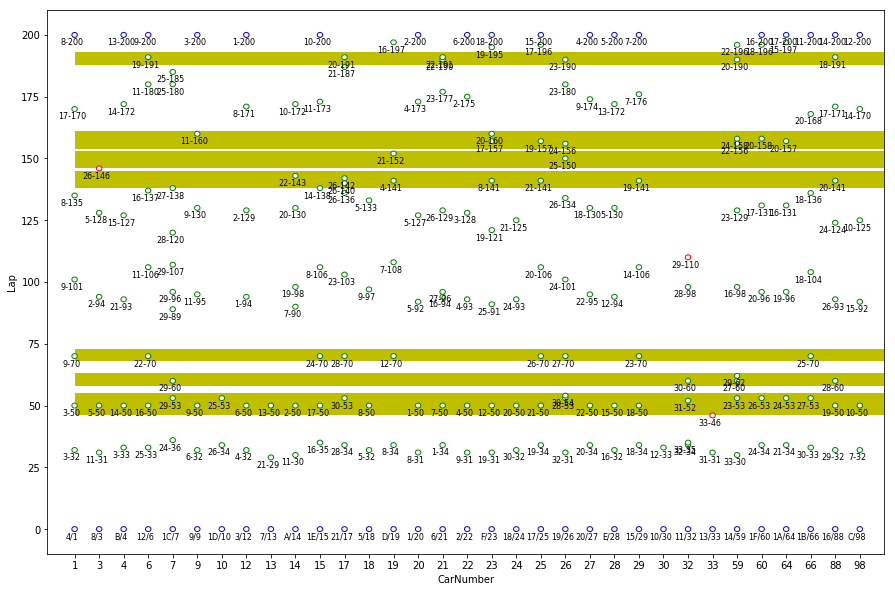

In [94]:
fig, ax = plt.subplots()#1,1,figsize=(8,15))
fig.set_size_inches(15,10)

xscale=int(100/11)  #(200*15)/(10*33)
carno = init_carno(xscale)
    
pits = []
yflag = []
#
# car_number / lap
#
boxsize = 1
for row in result:
    
    x = carno[int(row[colid['car_number']])]
    y = int(row[colid['completed_laps']])
    
    if row[colid['lap_status']]=='P':
        #pitid
        pitid = pitno[int(row[colid['car_number']])]
        pitno[int(row[colid['car_number']])] += 1
        
        # #rank-#carno-#laps-#pitid
        #txt = '#%d\n%d-%d'%(int(row[1]), row[0], pitid)
        #txt = '#%d-%d\n%d\n%d-%s'%(int(row[colid['rank']]), row[colid['car_number']],
        #                       row[colid['completed_laps']], pitid, row[colid['pit_stop_count']])
        #txt = '#%d'%(int(row[colid['rank']]))
        txt = '%d-%d'%(int(row[colid['rank']]),row[colid['completed_laps']])
        #color = 'g' if row[colid['track_status']]=='Y' else 'b'
        color = 'g'
                          
        if row[colid['current_status']] != 'Active':
            color = 'r'
        #pits.append((mpatch.Rectangle((x,y), boxsize, boxsize, color = color), txt))
        pits.append((mpatch.Circle((x,y), boxsize, fc='w',  ec = color), txt))
        #ax.text(x, y, txt, color=color)
    else:
        #other than pitstop
        color = 'b'
        if y == 200:
            #completed cars
            #txt = '#%d-%d\n%d\n%d-%s'%(int(row[colid['rank']]), row[colid['car_number']],
            #                       row[colid['completed_laps']], pitid, row[colid['pit_stop_count']])
            #txt = '#%d'%(int(row[colid['rank']]))
            txt = '%d-%d'%(int(row[colid['rank']]),row[colid['completed_laps']])
            
            pits.append((mpatch.Circle((x,y), boxsize, fc='w', ec = color), txt))
        elif y == 0:
            #start position
            #txt = '#%s-%d'%(row[colid['start_position']], row[colid['car_number']])
            txt = '%s/%d'%(row[colid['start_position']],row[colid['car_number']])
            pits.append((mpatch.Circle((x,y), boxsize, fc='w',  ec = color), txt))
        #else:
        #    pits.append((mpatch.Rectangle((x,y), 1, 1, color = 'gray'), ''))
    
    #ax.text(x, y, txt, color=color)
for yflag in yellowflags:
    ax.barh(yflag[0],33*xscale, height = yflag[1] - yflag[0], align='edge', color = 'y', zorder=-100)
    #ax.barh(yflag[0],33,align='edge', color = 'y', zorder=-100)
    
for r in pits:
    rect = r[0]
    ax.add_artist(rect)
    rx, ry = rect.get_center()
    cx = rx - boxsize*2/2.0
    cy = ry - boxsize*6/2.0

    if r[1] == '':
        ax.annotate(r[1], (cx, cy), color='gray', weight='bold', 
                fontsize=8, ha='center', va='center')
    else:
        ax.annotate(r[1], (cx, cy), color='k',  
                fontsize=8, ha='center', va='center',zorder=100)
  


#ax.set_xlim((0, 33))
ax.set_xlim((-10, 33*xscale))
ax.set_ylim((-10, 210))

x_car = [x*xscale for x in range(len(carno))]
ax.set_xticks(x_car)
ax.set_xticklabels([str(x) for x in carnumberset])

ax.set_ylabel('Lap')
ax.set_xlabel('CarNumber')

#ax.set_aspect('equal')
#fig.tight_layout()
fig.savefig(outputprefix + '_pitstop_bycarno_2.pdf')

carnumber: 33
{1: 0, 3: 1, 4: 2, 6: 3, 7: 4, 9: 5, 10: 6, 12: 7, 13: 8, 14: 9, 15: 10, 17: 11, 18: 12, 19: 13, 20: 14, 21: 15, 22: 16, 23: 17, 24: 18, 25: 19, 26: 20, 27: 21, 28: 22, 29: 23, 30: 24, 32: 25, 33: 26, 59: 27, 60: 28, 64: 29, 66: 30, 88: 31, 98: 32}


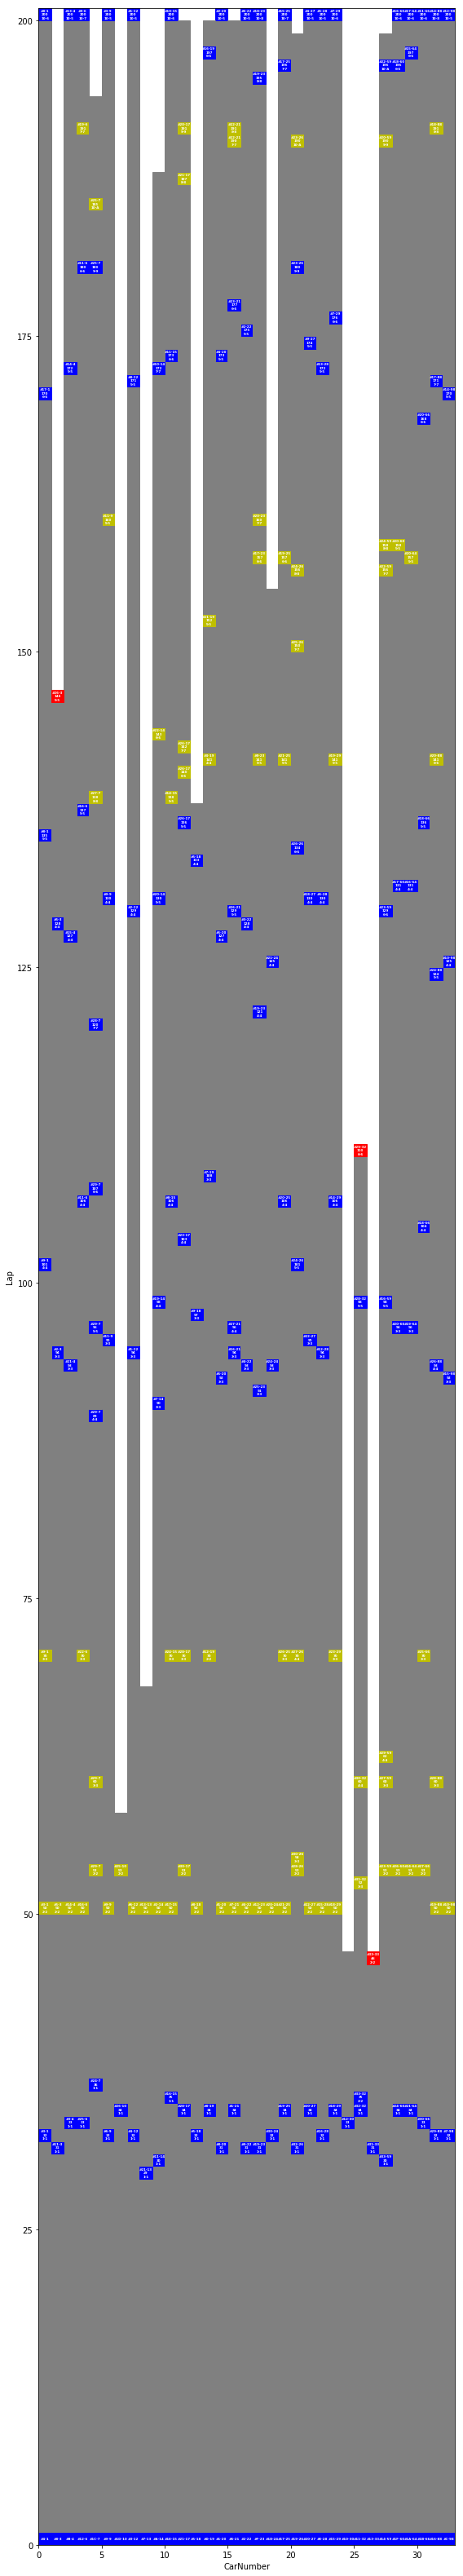

In [102]:
# detailed figure

carno = init_carno(1)
draw_boxview()

In [58]:
a = pitstop_data[(pitstop_data['completed_laps']==31) | (pitstop_data['completed_laps']==34)]
a = a[a['car_number'] == 19]
a

,completed_laps,rank,car_number,lap_status,track_status
MyIdx,,,,,
2742,31,12,19,T,G
3208,34,8,19,P,G


In [19]:
outputprefix

'2018-Indy500-'